<a href="https://colab.research.google.com/github/johntango/UniversalFuncApprox/blob/main/MixtureOfExperts001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of Mixture of Experts Approach
see https://huggingface.co/blog/moe

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# ------------------------------
# 1. Create Synthetic Dataset
# ------------------------------
# We'll create a simple 1D regression problem. For example:
#   y = sin(x) + 0.2 * noise
#   We'll make x in [-2π, 2π] to see interesting behavior.

torch.manual_seed(0)
np.random.seed(0)

N = 200
X = np.linspace(-2*np.pi, 2*np.pi, N)
Y = np.sin(X) + 0.1 * np.random.randn(N)

# Convert to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float).view(-1, 1)
Y_torch = torch.tensor(Y, dtype=torch.float).view(-1, 1)



In [ ]:
# ------------------------------
# 2. Define Expert Networks
# ------------------------------

class Expert(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, output_dim=1):
        super(Expert, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# ------------------------------
# 3. Define Gating Network
# ------------------------------

class GatingNetwork(nn.Module):
    def __init__(self, input_dim=1, num_experts=3):
        super(GatingNetwork, self).__init__()
        self.linear = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Output a distribution over experts using softmax
        logits = self.linear(x)
        return torch.softmax(logits, dim=-1)

# ------------------------------
# 4. Mixture of Experts Model
# ------------------------------

class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts=3, input_dim=1, hidden_dim=16, output_dim=1):
        super(MixtureOfExperts, self).__init__()

        # Create N experts
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim) for _ in range(num_experts)
        ])

        # Create gating network
        self.gating_network = GatingNetwork(input_dim, num_experts)

    def forward(self, x):
        # Get gating probabilities
        gating_probs = self.gating_network(x)  # shape: (batch_size, num_experts)

        # Get expert outputs
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # shape: (batch_size, 1)

        # Stack expert outputs -> (batch_size, num_experts, 1)
        expert_outputs = torch.stack(expert_outputs, dim=1).squeeze(-1)
        # expert_outputs shape is (batch_size, num_experts)

        # Weighted sum across experts
        # gating_probs: (batch_size, num_experts)
        # expert_outputs: (batch_size, num_experts)
        # => mixture: (batch_size, )
        mixture_output = torch.sum(gating_probs * expert_outputs, dim=1, keepdim=True)

        return mixture_output, gating_probs


In [ ]:
# ------------------------------
# 5. Training the MoE model
# ------------------------------

num_experts = 3
model = MixtureOfExperts(num_experts=num_experts, input_dim=1, hidden_dim=16, output_dim=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10000

X_train = X_torch
Y_train = Y_torch

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs, gating_probs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [500/10000], Loss: 0.0088
Epoch [1000/10000], Loss: 0.0086
Epoch [1500/10000], Loss: 0.0086
Epoch [2000/10000], Loss: 0.0083
Epoch [2500/10000], Loss: 0.0086
Epoch [3000/10000], Loss: 0.0086
Epoch [3500/10000], Loss: 0.0082
Epoch [4000/10000], Loss: 0.0083
Epoch [4500/10000], Loss: 0.0082
Epoch [5000/10000], Loss: 0.0081
Epoch [5500/10000], Loss: 0.0081
Epoch [6000/10000], Loss: 0.0081
Epoch [6500/10000], Loss: 0.0081
Epoch [7000/10000], Loss: 0.0083
Epoch [7500/10000], Loss: 0.0088
Epoch [8000/10000], Loss: 0.0081
Epoch [8500/10000], Loss: 0.0080
Epoch [9000/10000], Loss: 0.0081
Epoch [9500/10000], Loss: 0.0080
Epoch [10000/10000], Loss: 0.0080


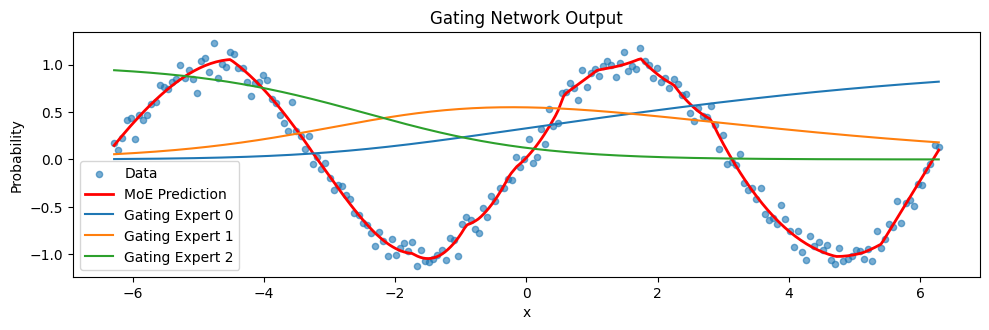

In [ ]:
# ------------------------------
# 6. Plot Results
# ------------------------------

# Evaluate model on a dense set of points for plotting
with torch.no_grad():
    X_plot = torch.linspace(-2*np.pi, 2*np.pi, 300).view(-1,1)
    y_pred, gating_pred = model(X_plot)
    y_pred = y_pred.detach().numpy()
    gating_pred = gating_pred.detach().numpy()

# Plot the learned gating probabilities
plt.figure(figsize=(10, 6))

# Subplot 1: Mixture output
plt.subplot(2, 1, 1)
plt.scatter(X, Y, label="Data", s=20, alpha=0.6)
plt.plot(X_plot.numpy(), y_pred, 'r-', label="MoE Prediction", linewidth=2)
plt.title("Mixture-of-Experts Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Subplot 2: Gating probabilities for each expert
for i in range(num_experts):
    plt.plot(X_plot.numpy(), gating_pred[:, i], label=f"Gating Expert {i}")
plt.title("Gating Network Output")
plt.xlabel("x")
plt.ylabel("Probability")
plt.legend()

plt.tight_layout()
plt.show()